# Mid term November 22, 2024

## Imports

In [1]:
import sympy
import math
from IPython.display import display, Math
from robotic.manipulator import JointType, Manipulator
from robotic.utils import draw_frame
from robotic.transformations import (
    Axis,
    EulerOrder,
    EulerSequence,
    HomogeneousTransformation,
    Rotation,
    Translation,
    X,
    Y,
    Z,
)


## Esercise 1

We begin by defining the initial orientation $R_i$ using fixed $ZXY$ euler angles, where the angles are known and can be substituted directly:

$$
\alpha = \frac{\pi}{2}, \beta = \frac{\pi}{4}, \gamma = \frac{\pi}{6}
$$

In [2]:
alpha = sympy.pi / 2
beta = sympy.pi / 4
gamma = -sympy.pi / 4
initial_rot: Rotation = Rotation.from_euler(
    (alpha, beta, gamma),
    EulerSequence.ZXY,
    EulerOrder.FIXED,
)
initial_rot.evalf().round(4)

Matrix([
[   0.5, -0.7071,     0.5],
[0.7071,       0, -0.7071],
[   0.5,  0.7071,     0.5]])

Next, the final orientation $R_f$ is specified using an axis-angle representation with axis of rotation and amount known:

$$
\bold{r} =(0, -\frac{\sqrt{2}}{2},\frac{\sqrt{2}}{2}), \quad \theta= \frac{\pi}{6}
$$ 

In [3]:
theta = sympy.pi / 6
r = Axis(0, -math.sqrt(2) / 2.0, math.sqrt(2) / 2.0)
final_rot = Rotation.from_axis_angle(r, theta)
final_rot.evalf().round()

Matrix([
[ 0.866, -0.3536, -0.3536],
[0.3536,   0.933,  -0.067],
[0.3536,  -0.067,   0.933]])

Now we compute the relative transformation $R_{if}$ which represents the rotation that brings the initial frame $R_i$ into alignment with the final frame $R_f$:

$$
R_f = R_i R_{if} \rightarrow R_{if} = R_i^T R_f
$$

In [4]:
r_trans: Rotation = initial_rot.T @ final_rot
r_trans.evalf().round()

Matrix([
[ 0.8598, 0.4495, 0.2424],
[-0.3624, 0.2026, 0.9097],
[ 0.3598,  -0.87, 0.3371]])

Finally we can extract the Eler angles $\phi, \chi, \psi$ around YXY assuming a fixed convention

In [5]:
(phi, chi, psi), _, _ = r_trans.to_euler(EulerSequence.YXY, EulerOrder.FIXED)
display(Math(rf"\phi = {phi.evalf(): .4f}"))  # type: ignore
display(Math(rf"\chi = {chi.evalf(): .4f}"))  # type: ignore
display(Math(rf"\psi = {psi.evalf(): .4f}"))  # type: ignore


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Excercise 2

In order to check the intermediate results we will define the required symbols

In [6]:
h, r, d, alpha, theta, phi = sympy.symbols("h r d alpha theta phi")

Now, from the figure we know that the cylinder frame is rotated relative to the world frame:

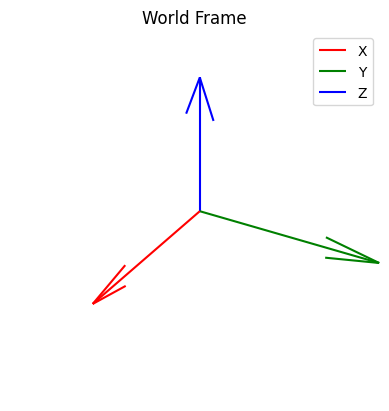

In [7]:
basis = Rotation(
    sympy.Matrix(
        [
            [0, 1, 0],
            [-1, 0, 0],
            [0, 0, 1],
        ]
    )
)
world_frame_rotation = draw_frame(basis=basis, label="World Frame")

From the image the cylinder is rotated by an amount of:

- $\frac{\pi}{2}$ around Y
- $\frac{\pi}{2}$ around Z


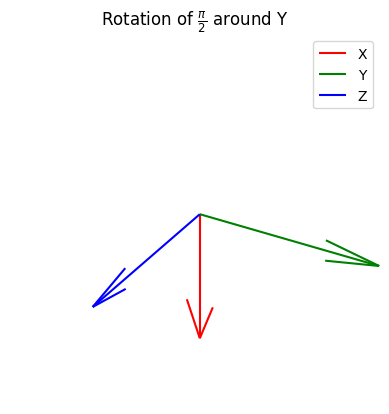

In [8]:
initial_rotation = draw_frame(
    rotation=Rotation.from_axis_angle(Y, sympy.pi / 2),
    basis=basis,
    label=r"Rotation of $\frac{\pi}{2}$ around Y",
)

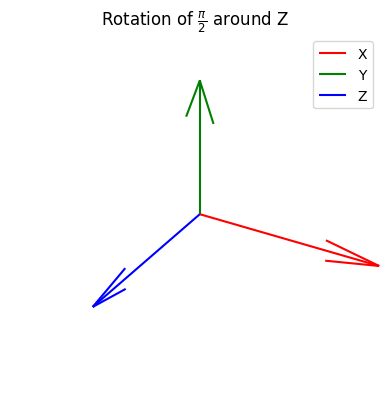

In [9]:
initial_rotation = draw_frame(
    rotation=Rotation.from_axis_angle(Z, sympy.pi / 2),
    basis=initial_rotation,
    label=r"Rotation of $\frac{\pi}{2}$ around Z",
)

We can define now an homogeneous transformation, ${}^wT_c$, that transforms from world frame into body frame, from this new initial rotation, however we need to also account for the displacement w.r.t to the center, due to the fact that we are taking the body of the cylinder, which is located at a distance of $\frac{h}{2}$ along the world frame $x$ axis and at a height of $r$, again in the world frame

In [10]:
# remove the information about the world frame basis definition
initial_rotation = basis.T @ initial_rotation
w_t_c = HomogeneousTransformation.from_rotation(initial_rotation).with_translation(
    Translation(h / 2, 0, r)
)
w_t_c

Matrix([
[0, 0, 1, h/2],
[1, 0, 0,   0],
[0, 1, 0,   r],
[0, 0, 0,   1]])

We roll for a distance $d$, however a roll will also cause a rotation $\alpha = \frac{d}{r}$, however since the roll will be clockwise $\alpha = -\frac{d}{r}$, so our first transformation $T_1$ will be described in body frame as:

In [11]:
t_1 = HomogeneousTransformation.from_rotation(
    Rotation.from_axis_angle(Z, alpha)
).with_translation(Translation(d, 0, 0))
t_1

Matrix([
[cos(alpha), -sin(alpha), 0, d],
[sin(alpha),  cos(alpha), 0, 0],
[         0,           0, 1, 0],
[         0,           0, 0, 1]])

We now rotate around the world frame Z axis, so in world frame $T_2$ will be described as

In [12]:
t_2 = HomogeneousTransformation.from_rotation(Rotation.from_axis_angle(Z, theta))
t_2

Matrix([
[cos(theta), -sin(theta), 0, 0],
[sin(theta),  cos(theta), 0, 0],
[         0,           0, 1, 0],
[         0,           0, 0, 1]])

Finally we need to define the last transformation $T_3$ which is a rotation along the cylinder Z axis

In [13]:
t_3 = HomogeneousTransformation.from_rotation(Rotation.from_axis_angle(Z, phi))
t_3

Matrix([
[cos(phi), -sin(phi), 0, 0],
[sin(phi),  cos(phi), 0, 0],
[       0,         0, 1, 0],
[       0,         0, 0, 1]])

Finally we can write the full transformation, by rememebering something very important, we first need to perform the first rotation ${}^wT_c$, which rotates into the body frame, now from here:

- any rotation in body frame will be postmultiplied
- any rotation in world frame will be premultiplied

$$
T = T_2 ({}^wT_c T_1 T_3)
$$ 

In [14]:
t = t_2 @ (w_t_c @ (t_1 @ t_3))
# sympy.simplify(t)
t

Matrix([
[-(-sin(alpha)*sin(phi) + cos(alpha)*cos(phi))*sin(theta), -(-sin(alpha)*cos(phi) - sin(phi)*cos(alpha))*sin(theta), cos(theta), -d*sin(theta) + h*cos(theta)/2],
[ (-sin(alpha)*sin(phi) + cos(alpha)*cos(phi))*cos(theta),  (-sin(alpha)*cos(phi) - sin(phi)*cos(alpha))*cos(theta), sin(theta),  d*cos(theta) + h*sin(theta)/2],
[               sin(alpha)*cos(phi) + sin(phi)*cos(alpha),               -sin(alpha)*sin(phi) + cos(alpha)*cos(phi),          0,                              r],
[                                                       0,                                                        0,          0,                              1]])

In [15]:
t = (
    HomogeneousTransformation(
        t.subs(
            {
                "h": 0.5,
                "r": 0.1,
                "d": 1.5,
                "theta": sympy.pi / 3,
                "phi": -sympy.pi / 2,
                # When a cylinder rotates of a displacement d
                # the angle is d/r
                "alpha": -1.5 / 0.1,
            }
        )
    )
    .evalf()
    .round(4)
)
t

Matrix([
[ 0.5632,  0.6579,   0.5, -1.174],
[-0.3251, -0.3798, 0.866, 0.9665],
[ 0.7597, -0.6503,     0,    0.1],
[      0,       0,     0,    1.0]])

## Exercise 3

The DH convention requires that we assign a coordinate frame to each joint such that:

- The $z_i$ axis corresponds to the axis of motion of the $i$-th joint
- The $x_i$ axis lies along the common normal between $z_i$ and $z_{i-1}$
- PER PROBLEM REQUEST: No axis should point into the sheet

We will start by visualizing the world frame that we will be using

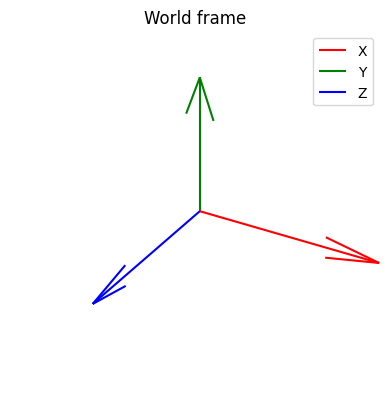

In [16]:
world_frame = draw_frame(
    label = "World frame"
).round().evalf()

Now we define Frame 0, which corresponds to the frame attached to the prismatic Joint 1, which is a sliding vertical joint.
Since the directionin which the joint moves is vertical.
Since this is the first frame that we are positioning, no previous frame exists and thus the requirement for $x_0$ is lifted and can be placed arbitrarily.
This means that we should only find a transformation $T_0$ that aligns $z_0$ with $y_w$.

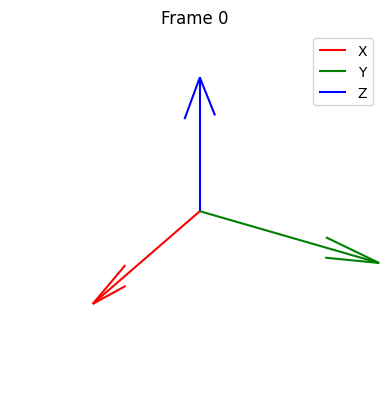

In [17]:
t_0 = draw_frame(
    Rotation.from_axis_angle(Z, -math.pi / 2)
    @ Rotation.from_axis_angle(Y, -math.pi / 2),basis= world_frame, label = "Frame 0"
).round().evalf()

Frame 1 corresponds to the second prismatic joint.
The axis is horizontal (in the world frame), so we need to find another transformation $T_1$ that allows us to move from Frame 0 to Frame 1 while respecting the constraints

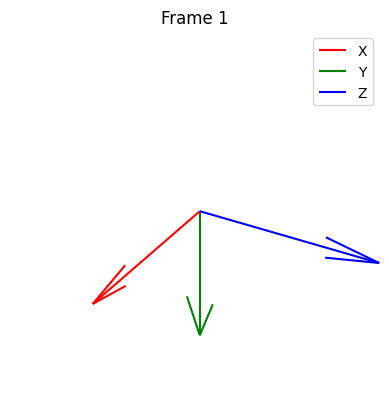

In [18]:
t_1 = draw_frame(Rotation.from_axis_angle(X,-math.pi/2), basis = t_0, label ="Frame 1").round().evalf()

Frame 2 is exactly the same as Frame 1 

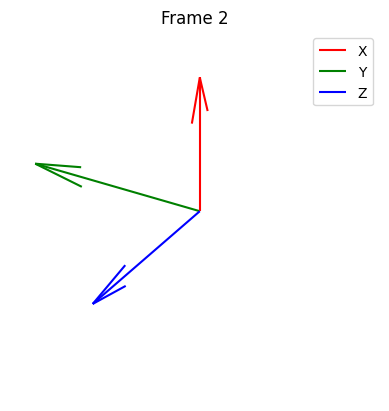

In [19]:
t_2 = draw_frame(Rotation.from_axis_angle(Z,-math.pi/2) @ Rotation.from_axis_angle(X,-math.pi/2),basis = t_1, label = "Frame 2").round().evalf()

<!-- TODO: Ask de luca how the third frame was decided  -->
Finally Frame 3 is placed at the gripper center ...

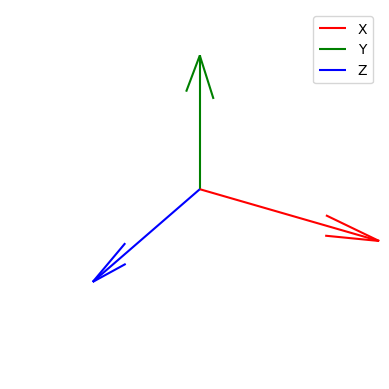

In [20]:
t_3 = draw_frame(Rotation.from_axis_angle(Z,-math.pi/2),basis = t_2).round().evalf()

And finally we need to add the End effector frame, but as the text suggests $z_e$ should be in the approach direction and $y_e$ should be in the slide direction.

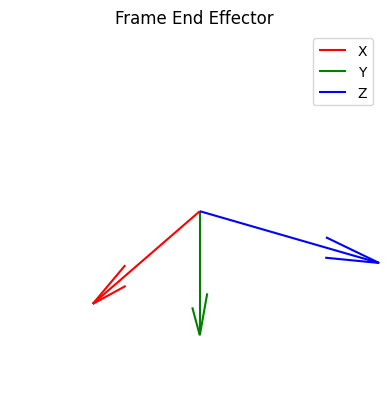

In [21]:
t_e = draw_frame(Rotation.from_axis_angle(Y,math.pi/2) @ Rotation.from_axis_angle(Z,math.pi), basis = t_3,label = "Frame End Effector").round().evalf()

Now that we have defined all axes, we can compute the DH table by interpreting the transformation between each pair of frames. We'll go parameter by parameter.

### Twist angle $\alpha_i$

> **With respect to $x_i$, how much do we need to rotate $z_{i-1}$ to align it with $z_i$?**

In practice, this is just the rotation around the X-axis between consecutive Z-axes. Since we aligned the axes visually, we can directly read the rotation by observing the relative orientation of $z_{i-1}$ and $z_i$.

- $\alpha_1 = -\frac{\pi}{2}$
- $\alpha_2 = -\frac{\pi}{2}$
- $\alpha_3 = 0$

*Note: These correspond to the rotations around X applied when constructing each frame using `draw_frame`.*

---

### Link length $a_i$

> **The distance from $z_{i-1}$ to $z_i$, measured along the $x_i$ direction.**

This is easier to reason about in most cases. There are only two main situations:

- If $z_{i-1}$ and $z_i$ are **parallel but not intersecting**, then $a_i = c$, where $c$ is the distance between them.
- If $z_{i-1}$ and $z_i$ **intersect or are colinear**, then $a_i = 0$.

In our case:

- $a_1 = 0$
- $a_2 = 0$
- $a_3 = L$ (since the third link extends a constant length along the $x_3$ direction)

---

### Offset $d_i$

> **The distance along the $z_{i-1}$ (or $z_i$) axis from the origin of frame $i-1$ to where the common normal meets it.**

This parameter is variable for **prismatic joints**, and constant (often zero) for **revolute joints**.

- $d_1 = q_1$ (first prismatic joint)
- $d_2 = q_2$ (second prismatic joint)
- $d_3 = 0$ (revolute joint)

---

### Joint angle $\theta_i$

> **The angle between $x_{i-1}$ and $x_i$, measured about the $z_{i-1}$ axis.**

We can simply check how much rotation occurred around the Z-axis between each pair of frames.

- $\theta_1 = 0$
- $\theta_2 = -\frac{\pi}{2}$
- $\theta_3 = q_3$ (revolute joint angle)


We can now generate the dh Matrix

In [22]:
joint_types = [
        JointType.PRISMATIC,
        JointType.PRISMATIC,
        JointType.REVOLUTE,
    ]

x_offsets = [0, 0, sympy.symbols("L")]
# alpha
x_rotations = [-sympy.pi / 2, -sympy.pi / 2, 0]
man = Manipulator(
    x_offsets=x_offsets,
    x_rotations=x_rotations,
    joint_types=joint_types,
    z_rotations=[0.0, -sympy.pi / 2, 0],
)
man.dh_table()



   a  alpha    d  theta       type
0  0  -pi/2  q_1    0.0  PRISMATIC
1  0  -pi/2  q_2  -pi/2  PRISMATIC
2  L      0    0    q_3   REVOLUTE

In [23]:
man.dh_matrix().evalf()

Matrix([
[        0,         0, 1.0,                 0],
[-sin(q_3), -cos(q_3),   0, -L*sin(q_3) + q_2],
[ cos(q_3), -sin(q_3),   0,  L*cos(q_3) + q_1],
[        0,         0,   0,               1.0]])

In [24]:
w_t_zero = world_frame.T @ t_0
w_t_zero

Matrix([
[  0, 1.0,   0],
[  0,   0, 1.0],
[1.0,   0,   0]])

In [25]:
three_t_e = t_3.T @ t_e
three_t_e

Matrix([
[  0,    0, 1.0],
[  0, -1.0,   0],
[1.0,    0,   0]])

In [26]:
(w_t_zero @ man.dh_matrix() @ three_t_e).evalf()

Matrix([
[  0, 1.0*cos(q_3), -1.0*sin(q_3), -1.0*L*sin(q_3) + 1.0*q_2],
[  0, 1.0*sin(q_3),  1.0*cos(q_3),  1.0*L*cos(q_3) + 1.0*q_1],
[1.0,            0,             0,                         0],
[  0,            0,             0,                       1.0]])

## Excercise 4

In gear-driven systems, the torque transmission from a motor to a load (link) can be optimized by matching the inertias through the transmission ratio. The fundamental matching condition is

$$
n = \sqrt{\frac{J_l}{J_m}}
$$

where 

- $n$ is the reduction ratio of the system 
- $J_l$ is the link inertia
- $J_m$ is the motor inertia

Since our goal is to find $J_m$ we can write:

$$
J_l = J_m n^2
$$

where $n$ is still unknow.

The reduction ratio tells us how angular velocity changes as motion is transferred through gears. When two gears mesh, the linear velocities at the contact point must match:

$$
r_A \omega_A = r_B \omega_B \rightarrow \omega_B = \frac{r_A}{r_B} \omega_A
$$

This leads to the definition of reduction ratio

$$
n_{AB} = \frac{\omega_A}{\omega_B} = \frac{r_A}{r_B}
$$

This ratio is:

- Greater than 1 if gear A is smaller than gear B (Actually amplification ratio)
- Smaller than 1 if gear B is smaller than gear A

With this in mind we can compute the partial reduction ratios:

- Between motor and encoder: $n_{me} = r_e/r_m$
- Between encoder and link: $n_{el} = r_e/r_l$

Combining them gives the total reduction ratio from motor to link:

$$
n = n_{me} n_{el} = \frac{r_e}{r_m}\frac{r_l}{r_e} = \frac{r_l}{r_m}
$$

N.B the reduction ratio from the encoder is cancelled, does not alter the system.


In [27]:
r_m =.5
r_e = 40
r_l = 10
j_m = 7.1e-4
n = r_l/r_m
j_l = j_m * n**2
display(Math(r"$n_{me}= "+f"{r_e/r_m}$"))
display(Math(r"$n_{el}= "+f"{r_l/r_e}$"))
display(Math(r"$n= "+f"{n}$"))
display(Math(r"$J_l= "+f"{j_l:.4f}$"))




<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now that we got the Link inertia $J_l$, knowing the torque $\tau_m$ in order to obtain the acceleration of the link $\ddot{\theta}_l$ we can use the torque balance formula

$$
\tau_m = J_m \ddot{\theta}_m + \frac{J_l\ddot{\theta}_l}{n}
$$

However due to what we said previously about the meaning of the reduction ration, we can write 

$$
\ddot{\theta}_m = n \ddot{\theta}_l, \quad J_l= J_m n^2
$$

So we can rearrange terms:

$$
\tau_m = J_m (n \ddot{\theta}_l) + \frac{J_l\ddot{\theta}_l}{n} \rightarrow
\ddot{\theta}_l = \frac{\tau_m n}{2 J_l}
$$

In [28]:
tau_m = 10
display(Math(r"$\ddot{\theta}_l = " + f"{(tau_m * n)/(2 * j_l): .4f}$"))

<IPython.core.display.Math object>

<!-- TODO: Ask De luca how to solve points 3 and 4, I've never seen the introduction of the resolution so it's not clear what the question is all about -->

## Exercise 5



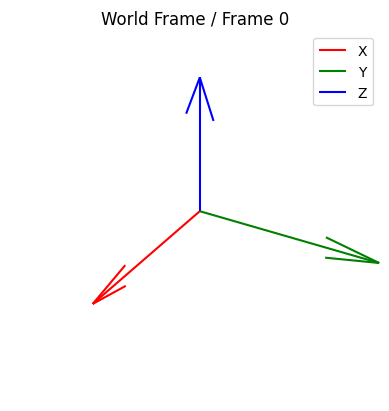

In [29]:
t_0 = draw_frame(Rotation.from_axis_angle(Y,-math.pi/2) @ Rotation.from_axis_angle(X,-math.pi/2), label = "World Frame / Frame 0")

In this case the common normal does not uniquely identifies a direction, so we must fix $z_1$ in the same direction as $z_0$ and we can arbitrarily set $x_1$ ($y_1$ is determined by the right handed frame rule).
However we have to take something into account, once we fix the initial Frame 1 as the revolute Joint 1 rotates, also Frame 1 rotates by an amount defined by $q_1$ 

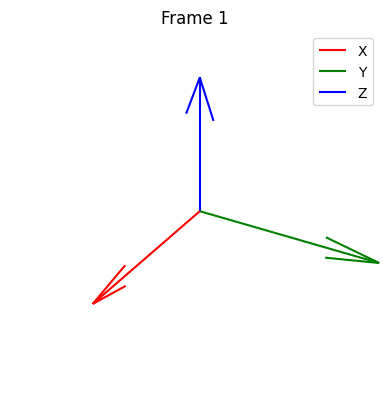

In [30]:
t_1 = draw_frame(basis = t_0, label = "Frame 1")

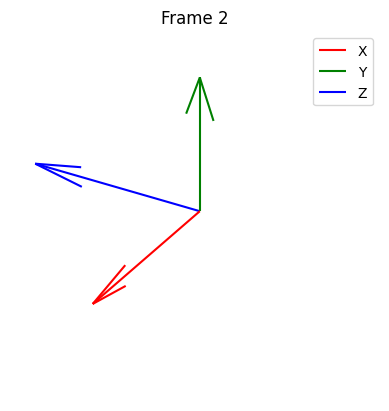

In [31]:
# Coherent with the DH table parameter
t_2 = draw_frame(rotation=Rotation.from_axis_angle(X,math.pi/2),basis = t_1, label = "Frame 2")

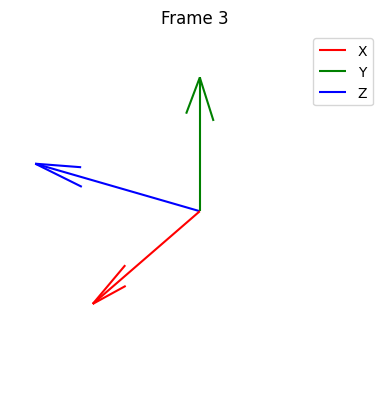

In [32]:
# from the table we should have no rotation so t_2 = t_3 -> colinear the commmon normal can be chosen arbitrarily
t_3 = draw_frame(basis = t_2, label = "Frame 3")


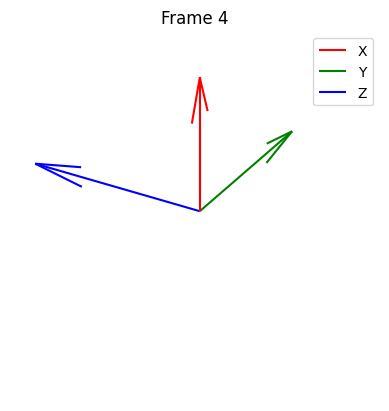

In [33]:
# TODO Ask de luca how tis last frame is computed.
t_4 = draw_frame(Rotation.from_axis_angle(Z,math.pi/2), basis = t_3, label = "Frame 4")

In [34]:
x_rotations = [ 0, sympy.pi/2, 0,0]
x_offsets = [0,0,0,sympy.symbols("L")]
joint_types =[
    JointType.REVOLUTE,
    JointType.PRISMATIC,
    JointType.PRISMATIC,
    JointType.REVOLUTE,

]
man = Manipulator(
    x_offsets=x_offsets,
    x_rotations=x_rotations,
    joint_types=joint_types
)
man.dh_table() # Should match the provided by the excercise

   a alpha    d theta       type
0  0     0    0   q_1   REVOLUTE
1  0  pi/2  q_2     0  PRISMATIC
2  0     0  q_3     0  PRISMATIC
3  L     0    0   q_4   REVOLUTE

In [35]:
t_e = (t_4.T @ t_e).round().evalf()

(man.dh_matrix()).evalf() # To check that it mat

Matrix([
[cos(q_1)*cos(q_4), -sin(q_4)*cos(q_1),  sin(q_1), L*cos(q_1)*cos(q_4) + q_3*sin(q_1)],
[sin(q_1)*cos(q_4), -sin(q_1)*sin(q_4), -cos(q_1), L*sin(q_1)*cos(q_4) - q_3*cos(q_1)],
[         sin(q_4),           cos(q_4),         0,                   L*sin(q_4) + q_2],
[                0,                  0,         0,                                1.0]])

Solving the inverse kinematic problem consists of determining the joint variables associated to a specific end-effector position.
There are two ways to solve this problem:

- Analytical solution: the result is a closed form system of equations, it can be found via geometric inspection and through algebraic methods
- Numerical solution: is found through the use of an iterative approach

As far as the analytical solution goes, we can employ some algebraic manipulations, keeping in mind that $\bold{r}(p_x,p_y,p_z)$ are known.
First we can easily see that: 

$$
q_4 = \alpha
$$

Now we can substitute in the other equations:

$$
p_x = L cos(q_1)cos(\alpha) + q_3 sin(q_1) \\
p_y = L sin(q_1)cos(\alpha) - q_3 cos(q_1) \\
p_z = L sin(\alpha) + q_2 \\
$$

$$
q_2 = p_z - L sin(\alpha)
$$


$$
p_x + p_y = L cos(\alpha) (cos(q_1) + sin(q_1)) + q_3 (sin(q_1) - cos(q_1))
$$

$$
p_x^2 = L^2 cos(q_1)^2 cos(\alpha)^2 + 2 L q_3 cos(q_1)cos(\alpha)sin(q_1) + q_3^2 sin(q_1) ^2 \\
p_y^2 = L^2 sin(q_1)^2 cos(\alpha)^2 - 2 L q_3 sin(q_1)cos(\alpha)cos(q_1) + q_3^2 cos(q_1) ^2 \\
p_x^2 + p_y^2 = L^2 cos(\alpha)^2 + q_3 ^2
$$

$$
q_3 = \pm \sqrt{p_x^2 + p_y^2 - L^2 cos(\alpha)^2}
$$

For the same end-effector position and orientation there can be two configurations of the robot arm:

- One where the joint $q_3$ moves forward
- One where the joint $q_3$ moves backward

That results in the same overall result.
This ambiguity comes from the special relationship that $q_1$ and $q_3$ have.
In particular the position along $x$ and $y$ is expressed as a combination of a rotation followed by a translation.
Both terms contain a trigonometric term in $q_1$ and a linear term in $q_3$.

The critical insight is that $q_3$ is computed as either a positive or negative root of a squared quantity. This implies that two values of exist, symmetric around zero, each associated with a different value of to preserve the correct direction of the vector in the plane. Geometrically, these represent two distinct configurations: one where the robot rotates to face the target point and extends positively along its frame, and one where the robot rotates in the opposite direction and extends negatively — yet both reach the same end-effector position in space.
Now we go back to the equations:

$$
p_x = L cos(q_1)cos(\alpha) + q_3 sin(q_1) \\
p_y = L sin(q_1)cos(\alpha) - q_3 cos(q_1) \\
$$

By treating $q_1$ as unknown we can write it as a linear system.

$$
\begin{pmatrix} L \cos \alpha_d & q_3^{+,-} \\ - q_3^{+,-} & L \cos \alpha_d \end{pmatrix} \begin{pmatrix} \cos q_1 \\ \sin q_1 \end{pmatrix} = \begin{pmatrix} p_{xd} \\ p_{yd} \end{pmatrix}
$$

But instead of solving the linear system symbolically and then dividing, we take advantage of a shortcut.

$$
q_1^{\pm} =  atan2(sin(q_1),cos(q_1))
$$